## Problem:
In recent years, the growing challenges in mental health have made it essential to develop innovative tools that can aid mental health professionals in diagnosing and assessing patients more effectively. To address this issue, our project, *Om*, focuses on utilizing Natural Language Processing (NLP) to predict a patient’s mental health status based on their written or spoken statements.

## Importance:
The core mission of *Om* is to enhance the accuracy and efficiency of mental health assessments by developing a predictive model that can classify statements into various mental health categories, such as Anxiety, Bipolar, Depression, Suicidal, Stress, Personality Disorder, and Normal. This data-driven approach is aimed at providing real-time support to therapists, enabling them to make more informed decisions based on objective analysis of patient statements. The ability to quickly and accurately predict a patient’s mental state is crucial for early intervention and timely support.

This notebook is a collaborative effort among three Machine Learning students from the University of Tennessee at Knoxville: Haoran Chen, Fort Hunter, and Ngan Huynh. Throughout this project, we spent considerable time exploring various techniques, refining our model, and incorporating effective visualizations. Along the way, we faced several challenges and setbacks, but we remained determined to find the best possible solution.

## Solution:
In our initial trials, we tested models such as HistGradientBoosting, RandomForestClassifier, and VotingClassifier. However, these approaches proved to be computationally expensive and time-consuming, with RandomForestClassifier in particular achieving a lower accuracy score of 0.68. This made it difficult for all team members to reach a consistent result. Furthermore, the improvements from these models were marginal, leading us to reconsider their use. After evaluating the performance and efficiency of the models, we decided to focus on a hypertuned Logistic Regression model. This model provided an accuracy of nearly 0.75 and offered a good balance between performance and computational efficiency. This decision allowed us to move forward with a more reliable and manageable model that could support mental health assessments effectively.

## 1. Import the Required Libraries

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import kagglehub
import os
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
import swifter
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import KFold
from wordcloud import WordCloud
from sklearn.model_selection import learning_curve
from collections import Counter
from scipy import stats
import random 
RANDOM_STATE = 42 # Please DO NOT modify this seed for reproducibility
random.seed(RANDOM_STATE)

In [90]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## 2. Download and Explore the dataset
### 2.1 Examine the Original Dataset

In [3]:
dataset_dir = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ModuleNotFoundError: No module named 'kaggle'

In [92]:
data = pd.read_csv(fr'{dataset_dir}/Combined Data.csv', index_col=0)
display(data)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [93]:
display(data.info())
print(f"Display Null values in the dataset:\n{data.isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


None

Display Null values in the dataset:
statement    362
status         0
dtype: int64


### 2.2 Replace the Null Statements with Empty Strings

In [94]:
data['statement'] = data['statement'].fillna('')
print("Null data after cleaning:", data['statement'].isnull().sum())
display(data.describe())

Null data after cleaning: 0


,statement,status
count,53043,53043
unique,51074,7
top,,Normal
freq,362,16351


### 2.3 Analyzing the Length of Original Statements

#### 2.3.1 Display the First Sample Statement for Each Unique Mental Health Status in the Valid Dataset

In [95]:
print("STATUSES AND SAMPLE STATEMENTS:")
print("\nAnxiety:\n", data.loc[data['status'] == 'Anxiety', 'statement'].iloc[0])
print("\nNormal:\n", data.loc[data['status'] == 'Normal', 'statement'].iloc[0])
print("\nDepression:\n", data.loc[data['status'] == 'Depression', 'statement'].iloc[0])
print("\nSuicidal:\n", data.loc[data['status'] == 'Suicidal', 'statement'].iloc[0])
print("\nStress:\n",data.loc[data['status'] == 'Stress', 'statement'].iloc[0])
print("\nBipolar:\n",data.loc[data['status'] == 'Bipolar', 'statement'].iloc[0])
print("\nPersonality disorder:\n",data.loc[data['status'] == 'Personality disorder', 'statement'].iloc[0])

STATUSES AND SAMPLE STATEMENTS:

Anxiety:
 oh my gosh

Normal:
 Gr gr dreaming of ex crush to be my game, God

Depression:
 I recently went through a breakup and she said she still wants to be friends so I said I can try doing that but when she talks to me about things it always hurts. I just want to lose feelings so all this pain can stop it hurts so much and I cannot even cry about it. I do not want to hurt her because she said she does not want to never speak to me again but I do not know what to do here. When we were together she always hurt me so I do not know why I still love her. I wish we never met it would be much less painful How do I lose feelings?

Suicidal:
 I am so exhausted of this. Just when I think I can finally rest, just when I think maybe things are starting to settle, another hurdle comes flying at me. This month alone we found out my mum could be dying, my girlfriend left me, my parents revealed that they wanted a divorce, my grandad was hospitalised again and jus

#### 2.3.2 Visualize the Distribution of Text Lengths in the Original Data

In [96]:
data['character_length'] = data['statement'].apply(len)
print(f"Longest line of text: {data['character_length'].max()} characters")
print(f"Shortest line of text: {data['character_length'].min()} characters")

Longest line of text: 32759 characters
Shortest line of text: 0 characters


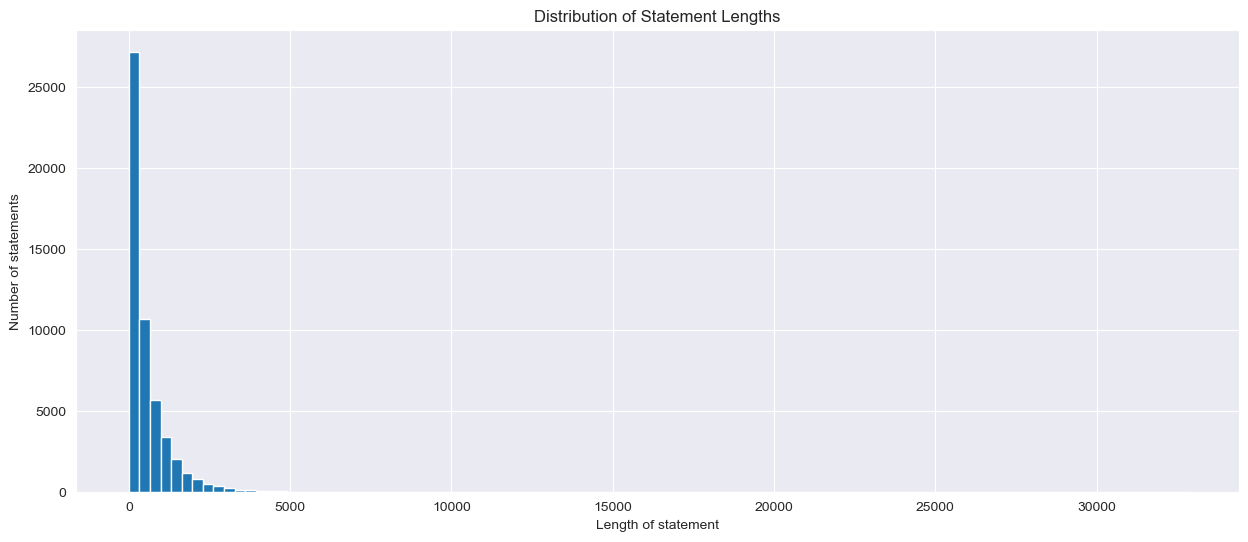

In [97]:
# Plot the statement lengths and their counts
plt.figure(figsize=(15, 6))
plt.hist(data['character_length'], bins=100)
plt.xlabel('Length of statement')
plt.ylabel('Number of statements')
plt.title('Distribution of Statement Lengths')
plt.show()

#### 2.3.3 Analyze Outliers and Extreme Values in Statement Lengths

In [98]:
display(data[data['character_length'] > 8000])

,statement,status,character_length
7851,So introduction I guess.. my name is Michael a...,Depression,10679
8221,do not really know where to start so I am goin...,Depression,8346
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390
11537,"The title is not meant to discourage others, b...",Depression,12304
11581,I no longer know what else to do but write thi...,Depression,13530
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122
13188,I am frustrated. that is the constant theme wi...,Depression,9665


In [99]:
display(data.describe())

,character_length
count,53043.000000
mean,574.764342
std,844.721094
min,0.000000
25%,77.000000
50%,313.000000
75%,748.000000
max,32759.000000


### 2.4 Analyze the Frequency of Each Status Category in the Dataset

Unique mental health statuses: ['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']
Total counts of each unique mental health status: 
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


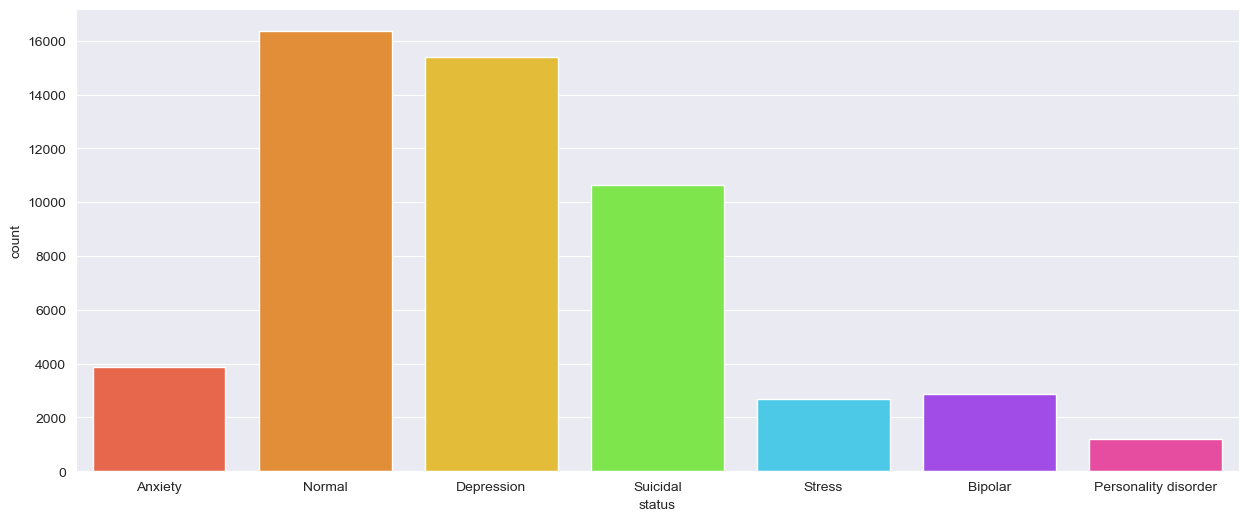

In [100]:
# Print unique statuses as objects for checking
print(f"Unique mental health statuses: {data['status'].unique()}")
print(f"Total counts of each unique mental health status: \n{data['status'].value_counts()}")

colors = ['#FF5733', '#FF8D1A', '#FFCD1D', '#75FF33', '#33D9FF', '#A433FF', '#FF33A2']
# Plot the mental health statuses and their counts
plt.figure(figsize=(15, 6))
sns.countplot(x='status', data=data, palette=colors, hue='status')
plt.show()

## 3. Encode Mental Health Statuses as Numerical Labels for Analysis

In [101]:
label_encoder = LabelEncoder()

# Encode categorical labels as integers
data['labeled_status'] = label_encoder.fit_transform(data['status'])

# Print unique statuses as numbers for checking
unique_labels = np.unique(data['labeled_status'])
print(f"Encoded unique mental statuses: {unique_labels}")

# Print the mapping of encoded labels to the original labels
print("Mapping of encoded labels to original labels:")
for encoded, original in zip(unique_labels, label_encoder.classes_):
    print(f"{encoded}: {original}")

Encoded unique mental statuses: [0 1 2 3 4 5 6]
Mapping of encoded labels to original labels:
0: Anxiety
1: Bipolar
2: Depression
3: Normal
4: Personality disorder
5: Stress
6: Suicidal


In [102]:
df =pd.DataFrame()
df['The Length of Statements'] = data['character_length']
df['The Number of Words'] = data['statement'].apply(lambda x: len(x.split()))
df.dropna(inplace = True)
df['Average Length of Words'] = np.round(df['The Length of Statements'] / df['The Number of Words'])
df['Average Length of Words'] = df['Average Length of Words'].fillna(0).replace([np.inf, -np.inf], 0).astype(int)
df['Size of Vocabulary'] = data['statement'].apply(lambda x: len(set(x.split())))
df['status'] = data['status']
df['labeled_status'] = data['labeled_status']
df.head()

,The Length of Statements,The Number of Words,Average Length of Words,Size of Vocabulary,status,labeled_status
0,10,3,3,3,Anxiety,0
1,64,10,6,10,Anxiety,0
2,78,14,6,13,Anxiety,0
3,61,11,6,11,Anxiety,0
4,72,14,5,14,Anxiety,0


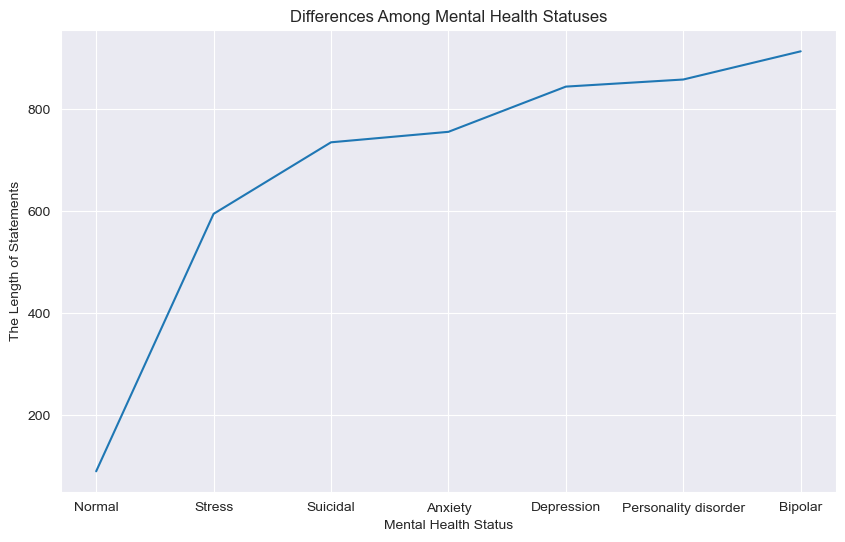

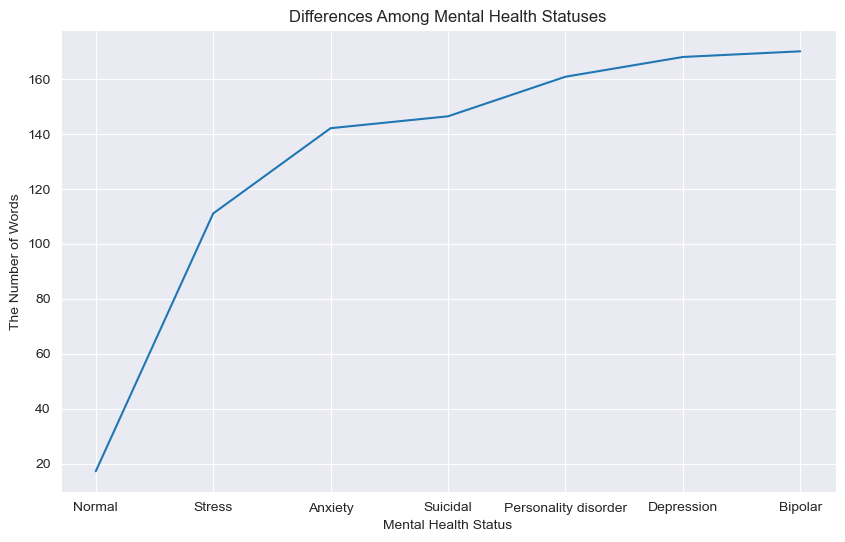

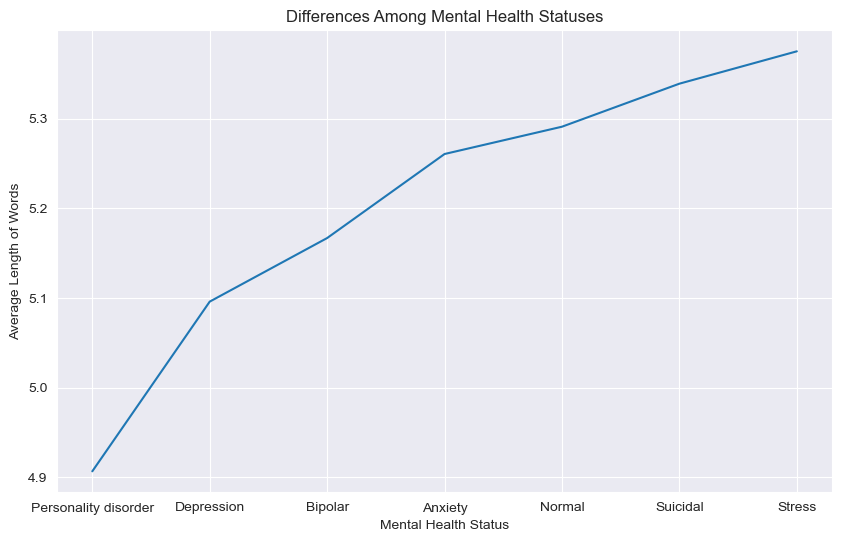

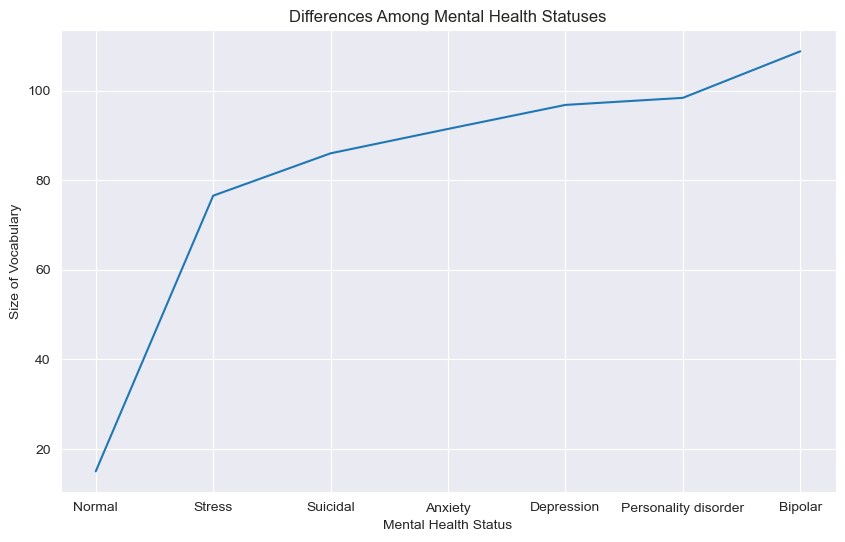

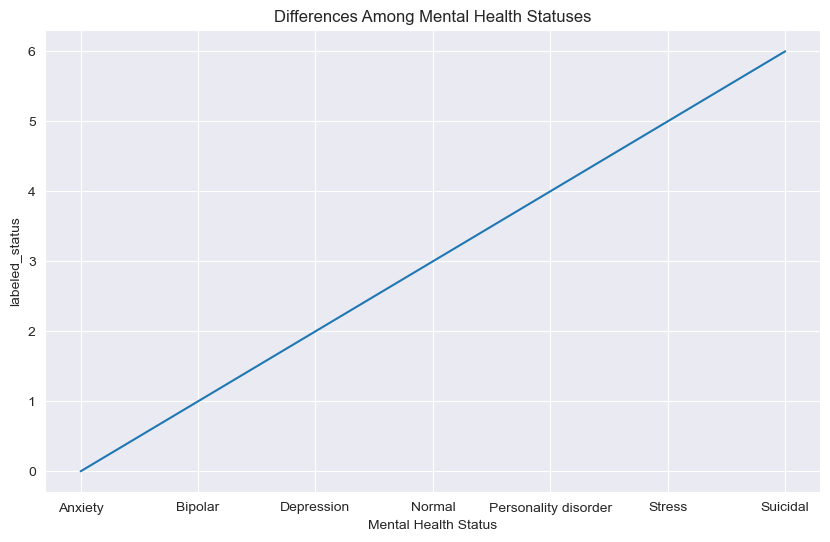

In [103]:
num_feature = [feature for feature in df.columns if df[feature].dtype != 'O']

for feature in num_feature:
    plt.figure(figsize=(10, 6))
    df.groupby('status')[feature].mean().sort_values().plot()
    plt.title("Differences Among Mental Health Statuses")
    plt.xlabel("Mental Health Status")  # Add x-axis label
    plt.ylabel(f"{feature}")  # Add y-axis label, dynamically using feature name
    plt.show()

## 4. Text Preprocessing

In [104]:
# Processing text function
def process_text(raw_text):    
    ## Lowercase raw text
    raw_text = raw_text.lower()
    ## Remove symbols that do not convey emotion
    raw_text = re.sub(r'https?://\S+|www\.\S+', '', raw_text) # Remove URLs
    raw_text = re.sub(r'\[.*?\]\(.*?\)', '', raw_text) # Remove markdown-style links
    raw_text = re.sub(r'#', '', raw_text) # Remove hashtags (only removing the # symbol from the word)
    raw_text = re.sub(r'<.*?>+', '', raw_text)  # Remove HTML tags
    raw_text = re.sub(r'[%s]' % re.escape(string.punctuation), '', raw_text)  # Remove punctuation
    raw_text = re.sub(r'\n', '', raw_text)  # Remove newlines
    raw_text = re.sub(r'\w*\d\w*', '', raw_text)  # Remove words containing numbers

    ## Tokenize the text using TweetTokenizer
     # TweetTokenizer also removes tokens starting with '@' 
    tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tweet_tokenizer.tokenize(raw_text)

    ## Remove stopwords
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'but', 'would', 'could'}
    filtered_tokens = [ token for token in tokens 
                        if token not in stop_words and not token.isspace()]
    
    # pos tagging - assign parts of speech to each word in the text
    tagged_tokens = pos_tag(filtered_tokens)
    # Lemmatize based on POS tags
    lemmatized_tokens = []
    lemmatizer = WordNetLemmatizer()

    for word, tag in tagged_tokens:
        # Convert the POS tag to WordNet POS tag format
        if tag.startswith('NN'):
            pos = 'n'  # Nouns
        elif tag.startswith('VB'):
            pos = 'v'  # Verbs
        elif tag.startswith('JJ'):
            pos = 'a'  # Adjectives
        elif tag.startswith('RB'):
            pos = 'r'  # Adverbs
        else:
            pos = 'n'  # Default to noun if unable to determine

        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))

    # Join the lemmatized tokens into a string
    processed_text = ' '.join(lemmatized_tokens)
    
    # return processed_text
    return processed_text

In [105]:
data['cleaned_statement'] = data['statement'].swifter.progress_bar(True).apply(lambda x: process_text(x))

Pandas Apply:   0%|          | 0/53043 [00:00<?, ?it/s]

In [106]:
# Ensure no NaN values are left
print(f"Null values in the dataset after cleaning:\n{data.isnull().sum()}")

Null values in the dataset after cleaning:
statement            0
status               0
character_length     0
labeled_status       0
cleaned_statement    0
dtype: int64


## 5. Visualize cleaned data before training

### 5.1 Distribution of Text Lengths
Showing the difference in statement length before and after cleaning

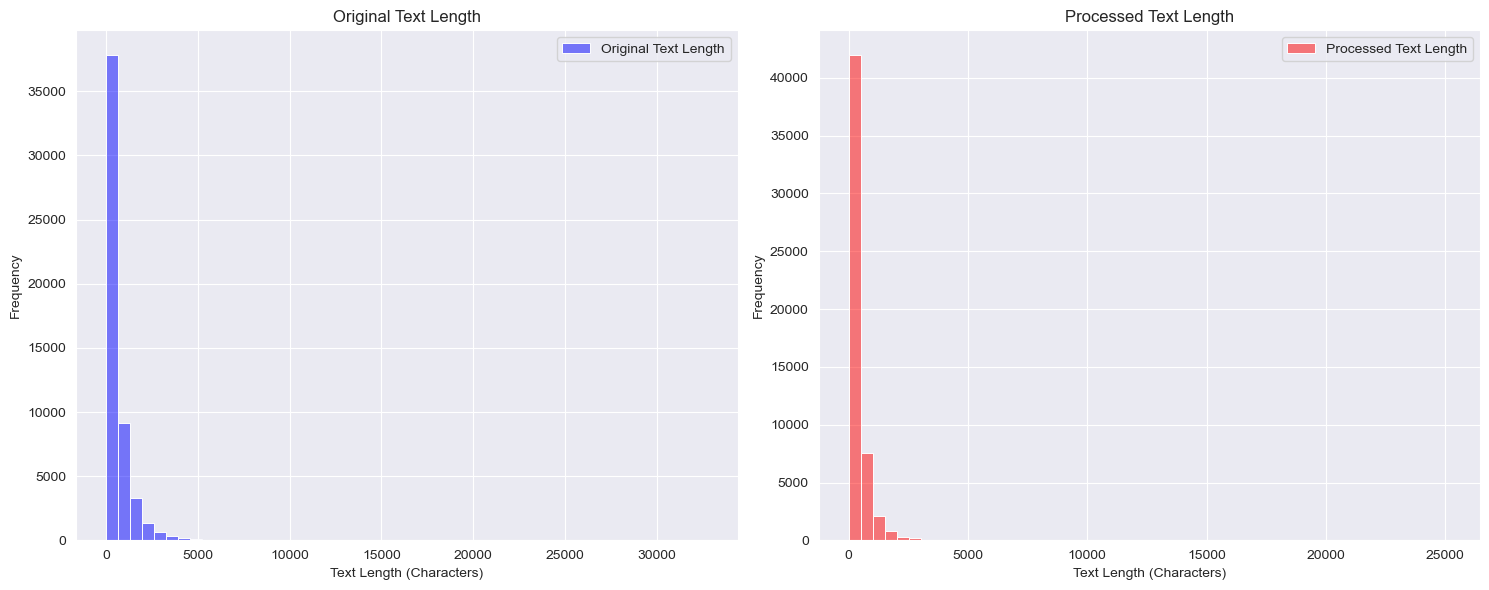

In [107]:
data['original_length'] = data['statement'].apply(len)
data['cleaned_length'] = data['cleaned_statement'].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data['original_length'], bins=50, color='blue', label='Original Text Length', alpha=0.5, ax=axes[0])
axes[0].set_xlabel('Text Length (Characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Text Length')
axes[0].legend()

sns.histplot(data['cleaned_length'], bins=50, color='red', label='Processed Text Length', alpha=0.5, ax=axes[1])
axes[1].set_xlabel('Text Length (Characters)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Processed Text Length')
axes[1].legend()

plt.tight_layout()
plt.show()

### 5.2 Compare the Most Frequent Words in Original and Cleaned Text

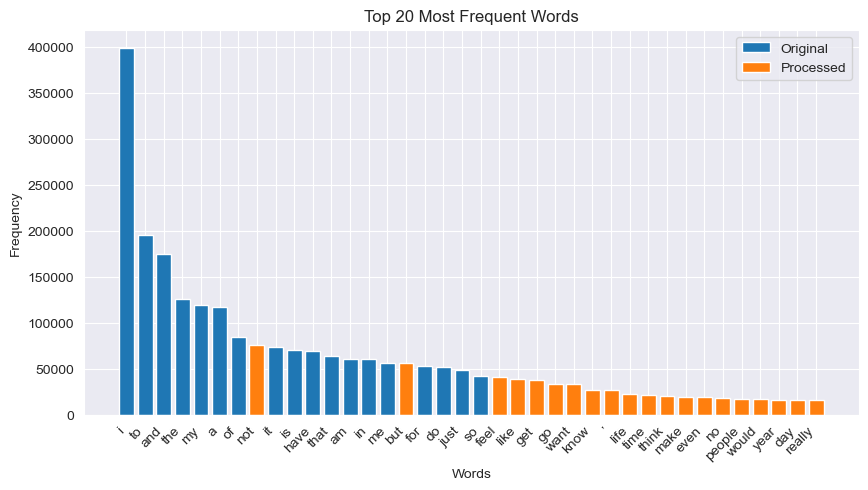

In [108]:
original_words = ' '.join(data['statement']).lower().split()
cleaned_words = ' '.join(data['cleaned_statement']).lower().split()

original_word_counts = Counter(original_words).most_common(20)
cleaned_word_counts = Counter(cleaned_words).most_common(20)
plt.figure(figsize=(10, 5))
plt.bar(*zip(*original_word_counts), label='Original')
plt.bar(*zip(*cleaned_word_counts), label='Processed')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.show()

## 6. Prepare the Data for Training
### 6.1 Separate the Features and Labels

In [109]:
X = data['cleaned_statement']
y = data['labeled_status']

### 6.2 Apply TF-IDF (Term Frequency-Inverse Document Frequency)
TF-IDF converts text into numerical features by calculating how important a word is in a specific document compared to the entire dataset. It rebalances the influence of words by reducing the weight of frequently occurring but less informative words (e.g., "the," "really") while highlighting rare yet meaningful words critical for distinguishing between categories. It also scales the transformed features to a normalized range, typically between 0 and 1, ensuring the dataset is balanced and optimized for training machine learning models.

In [110]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=RANDOM_STATE)

tfidf_terms = vectorizer.get_feature_names_out()
tfidf_scores = X_train.mean(axis=0)

In [125]:
# Convert TF-IDF features from float64 to float32 for efficient memory usage
X_tfidf = X_tfidf.astype('float32')
print("Shape of the final TF-IDF matrix:", X_tfidf.shape)

Shape of the final TF-IDF matrix: (53043, 5000)


### 6.3 Visualize Terms with Their TF-IDF Scores

#### 6.3.1 Distribution of TF-IDF Scores with Logarithmic Scale for Clearer Visualization of Low-Frequency Terms

In [112]:
tfidf_df = pd.DataFrame({'Term': tfidf_terms})
# Calculate TF-IDF scores grouped by status
status_scores = []
for status in unique_labels:
    # Get rows in X_train corresponding to the current status
    mask = y_train == status
    status_X_train = X_train[mask]
    
    # Compute average TF-IDF scores for the current status
    avg_scores = status_X_train.mean(axis=0)
    status_scores.append(pd.DataFrame({
        'Term': tfidf_terms,
        'Tfidf_score': avg_scores,
        'Status': status
    }))

# Combine all status-specific DataFrames
tfidf_status_df = pd.concat(status_scores)

# Sort by status and TF-IDF scores
tfidf_status_df = tfidf_status_df.sort_values(by=['Status', 'Tfidf_score'], ascending=[True, False])
status_labels = label_encoder.classes_
tfidf_status_df['Status'] = tfidf_status_df['Status'].map(lambda x: status_labels[x])

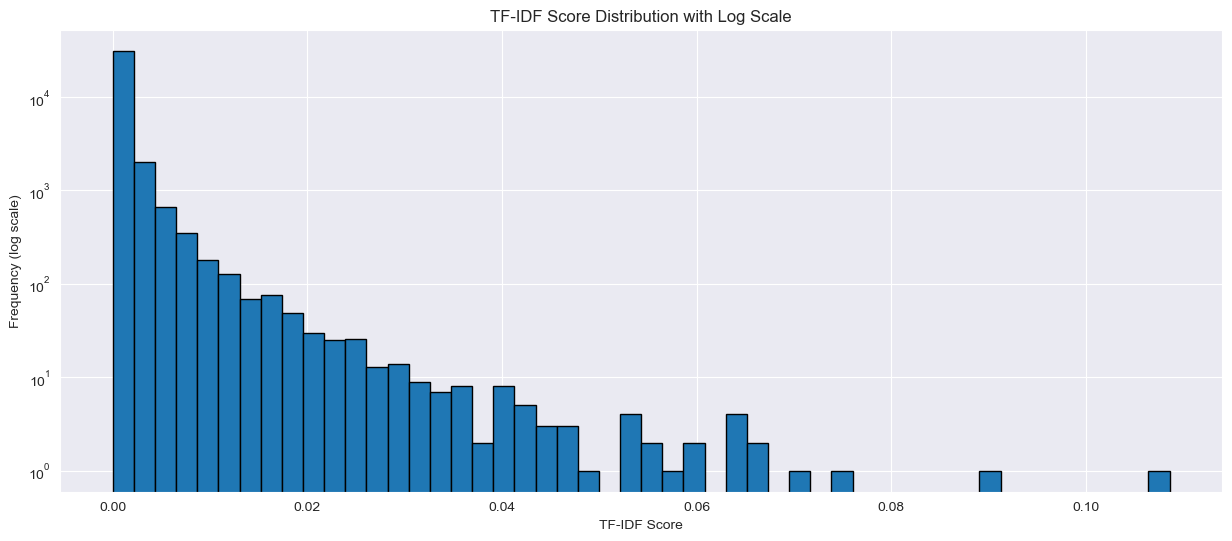

In [113]:
# Create a bar chart with log scale for better visualization of all values
plt.figure(figsize=(15, 6))
plt.hist(tfidf_status_df['Tfidf_score'] , bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency (log scale)')
plt.title('TF-IDF Score Distribution with Log Scale')
plt.show()


#### 6.3.2 Plot the 20 Most Important Terms in the Entire Dataset

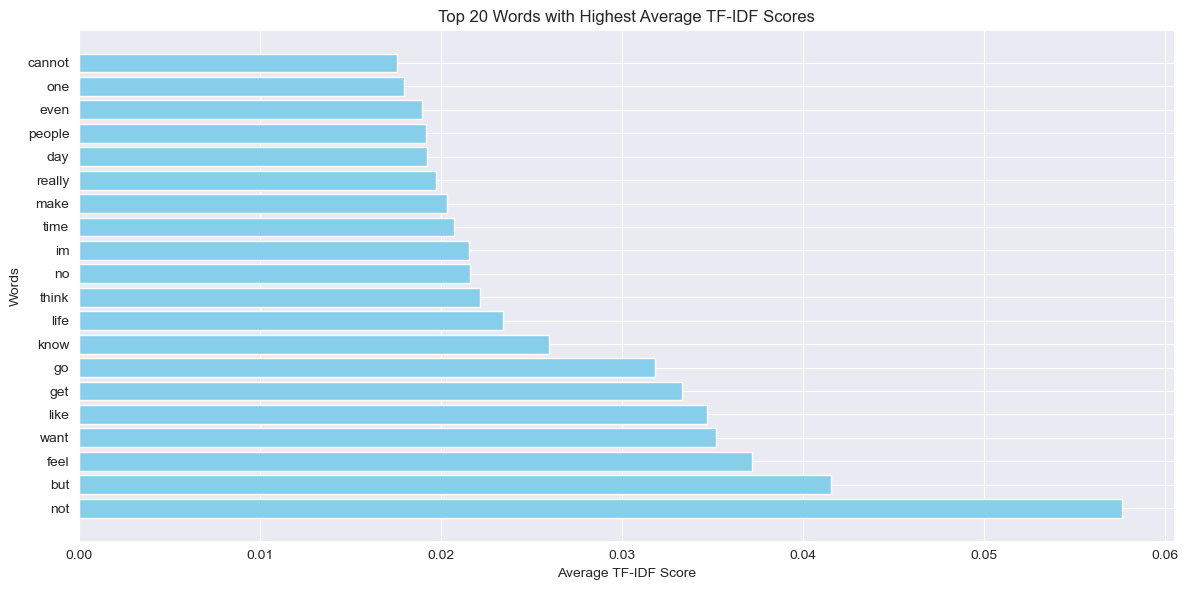

In [114]:
top_feature_indices = np.argsort(tfidf_scores)[-20:]
top_feature_names = [tfidf_terms[i] for i in top_feature_indices]
top_feature_scores = [tfidf_scores[i] for i in top_feature_indices]

plt.figure(figsize=(12, 6))
plt.barh(top_feature_names, top_feature_scores, color='skyblue')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Words')
plt.title('Top 20 Words with Highest Average TF-IDF Scores')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### 6.3.3 Plot the 5 Most Important Terms for Each Status Based on Average TF-IDF Scores

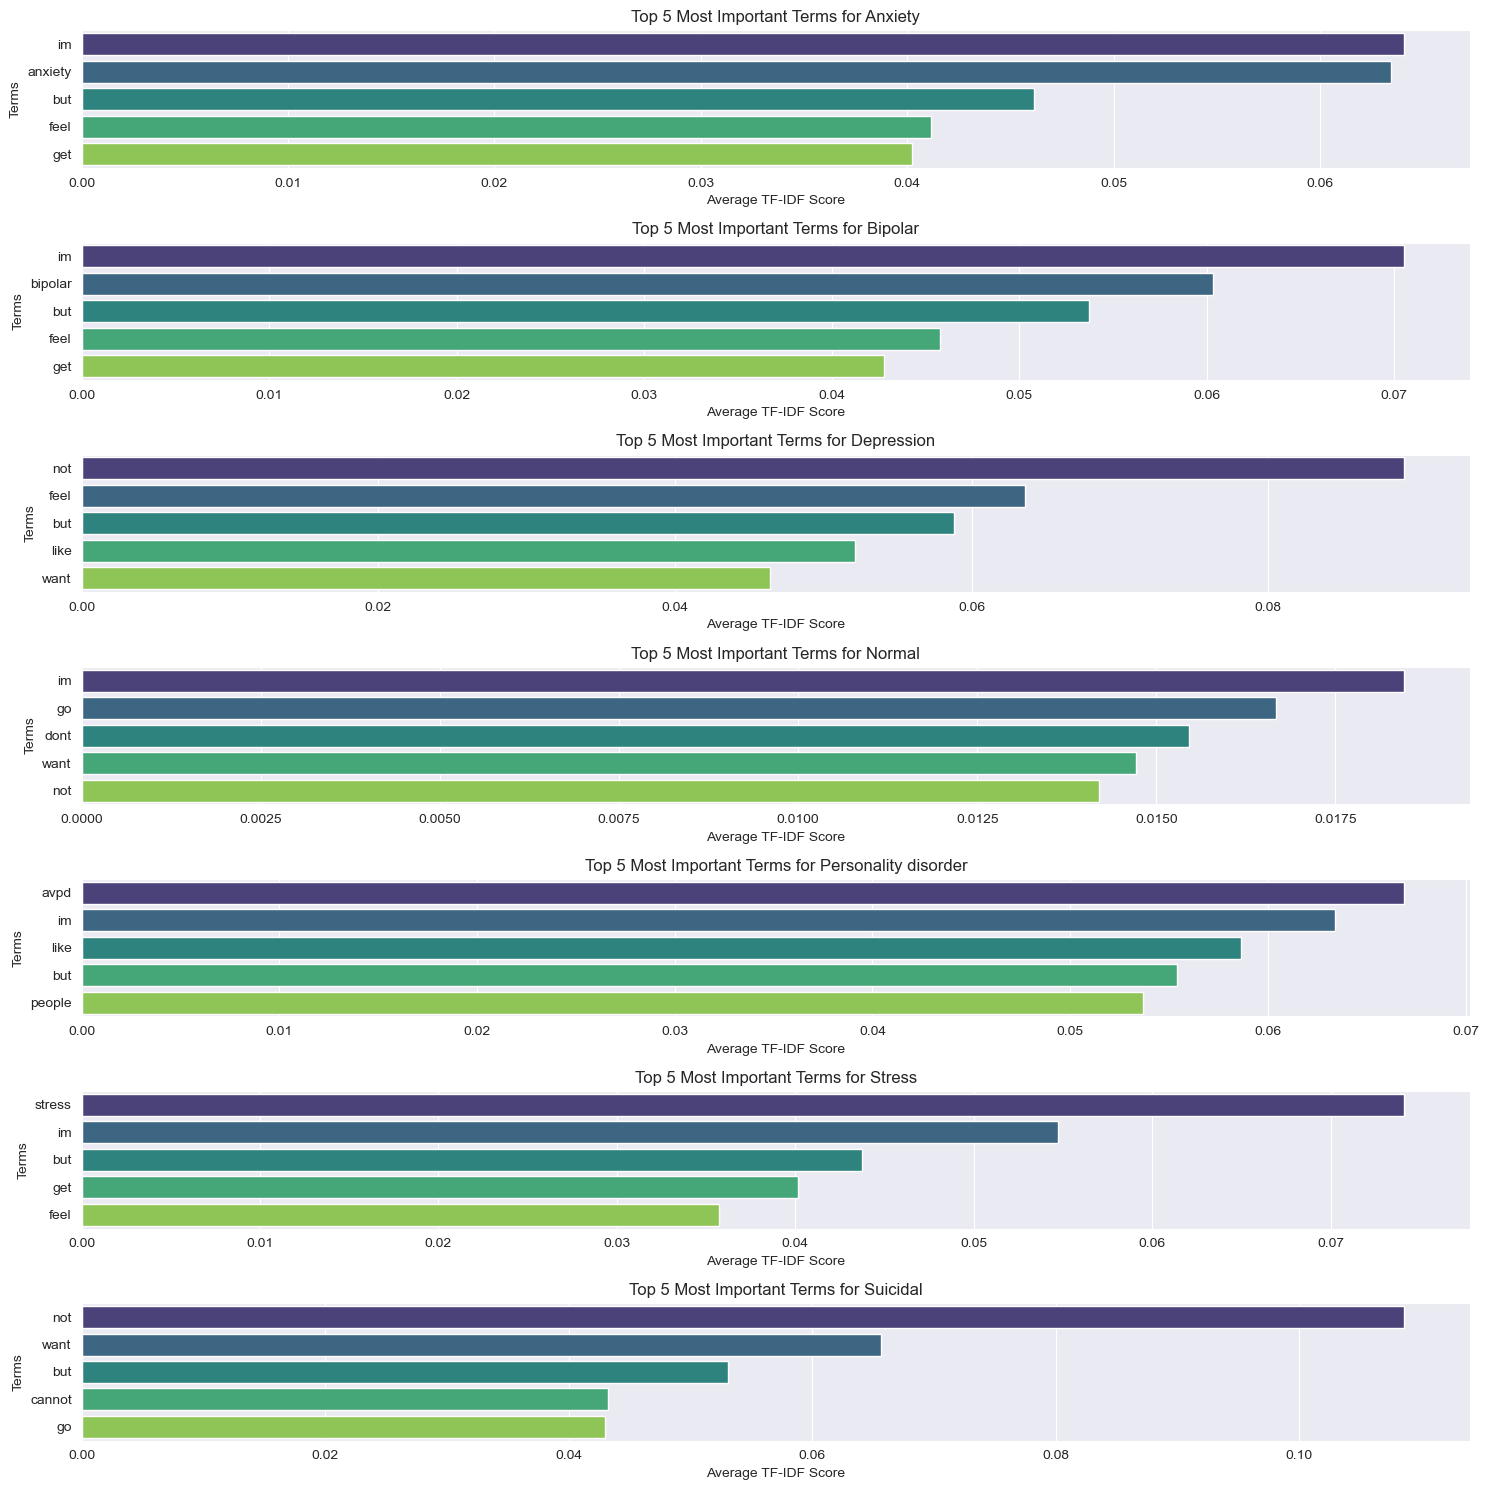

In [115]:
top_n = 5
plt.figure(figsize=(15, 15))

for i, status in enumerate(status_labels):
    # Get the status-specific DataFrame and the top N terms based on their average TF-IDF scores
    status_df = tfidf_status_df[tfidf_status_df['Status'] == status].head(top_n)
    
    # Plotting the top terms for the current status
    plt.subplot(len(status_labels), 1, i+1)
    sns.barplot(x='Tfidf_score', y='Term', data=status_df, palette='viridis')
    plt.title(f'Top {top_n} Most Important Terms for {status}')
    plt.xlabel('Average TF-IDF Score')
    plt.ylabel('Terms')

plt.tight_layout()
plt.show()

#### 6.3.4 Generate Word Clouds for Each Status Based on TF-IDF Scores

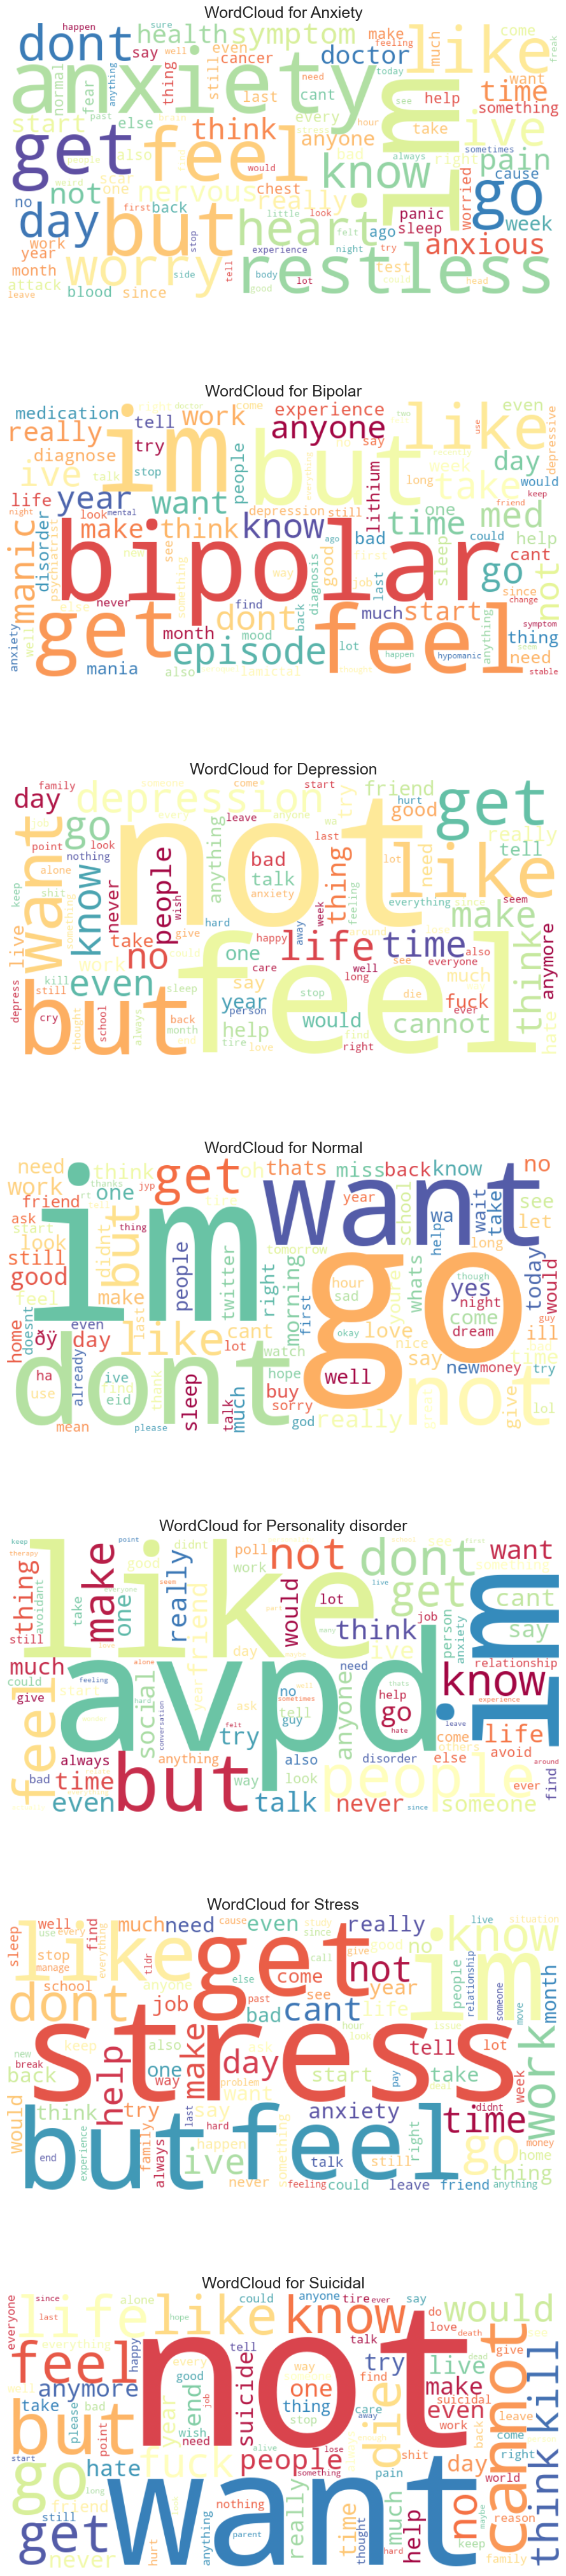

In [116]:
num_statuses = len(tfidf_status_df['Status'].unique())
fig, axes = plt.subplots(nrows=num_statuses, figsize=(9, 6 * num_statuses))

for i, status in enumerate(tfidf_status_df['Status'].unique()):
    # Filter the terms by status
    status_terms = tfidf_status_df[tfidf_status_df['Status'] == status]
    
    # Convert the terms and TF-IDF scores to a dictionary for WordCloud
    term_dict = dict(zip(status_terms['Term'], status_terms['Tfidf_score']))
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Spectral',
        max_words=100, 
        relative_scaling=0.5,
    ).generate_from_frequencies(term_dict)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'WordCloud for {status}', fontsize=18)

# Adjust layout
plt.tight_layout()
plt.show()

### 7. Model Training and Evaluation
#### 7.1 Train Logistic Regression Model with Hyperparameter Tuning and Visualization of Training and Validation Loss
* Train a Logistic Regression model and tune its hyperparameters using techniques like GridSearchCV.
* Explore different combinations of hyperparameters, such as C, penalty, and solver, to identify the best model configuration.
* Visualize the training and validation loss to understand the model’s behavior and assess whether it is overfitting or underfitting.
* Plot how the training and validation scores change across different hyperparameter values.
* Gain insights into the model's performance and its generalization ability through these visualizations.

In [117]:
# Initialize the Logistic Regression model with specified parameters and set up 10-fold cross-validation
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear')
# Cross-validation folds
kf = KFold(n_splits=10)

Best hyperparameters: {'C': 1, 'penalty': 'l1'}
Test accuracy:  0.7529


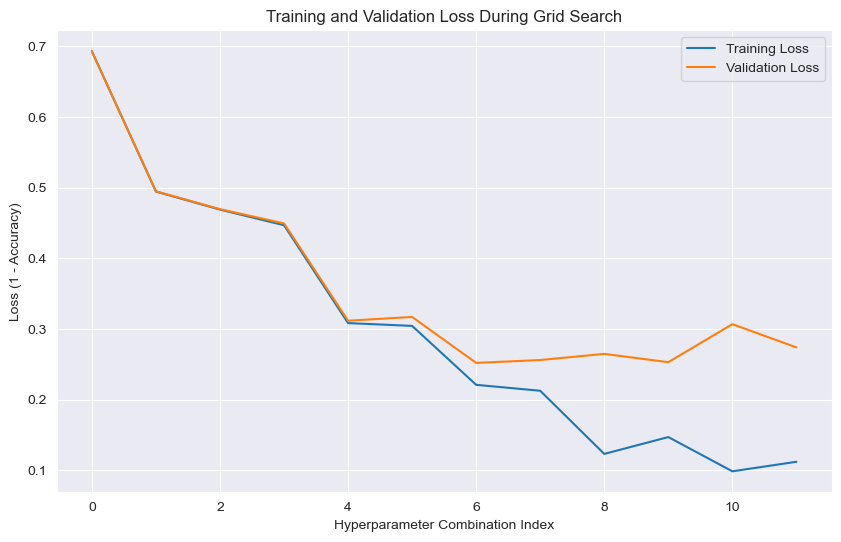

In [118]:
train_loss = []
val_loss = []

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ['l1', 'l2'],
}
grid_search = GridSearchCV(log_reg, param_grid, cv=kf, scoring="accuracy",
                           return_train_score=True)
grid_search.fit(X_train, y_train)
print(f"Best hyperparameters: {grid_search.best_params_}")
best_LR = grid_search.best_estimator_
best_accuracy_test_LR = best_LR.score(X_test, y_test)
print(f"Test accuracy: {best_accuracy_test_LR: .4f}")

for i in range(len(grid_search.cv_results_['params'])):
    train_loss.append(1 - grid_search.cv_results_['mean_train_score'][i])
    val_loss.append(1 - grid_search.cv_results_['mean_test_score'][i])

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Hyperparameter Combination Index")
plt.ylabel("Loss (1 - Accuracy)")
plt.title("Training and Validation Loss During Grid Search")
plt.legend()
plt.show()

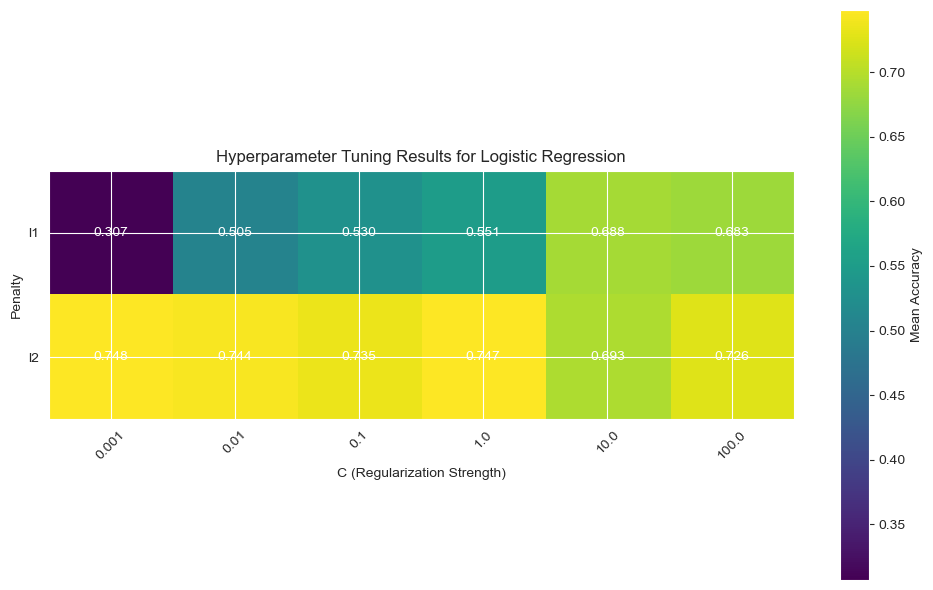

In [119]:
results = grid_search.cv_results_

mean_scores = results['mean_test_score']
C_values = results['param_C'].data
penalty_values = results['param_penalty'].data

C_unique = np.unique(C_values)
penalty_unique = np.unique(penalty_values)
C_grid, penalty_grid = np.meshgrid(C_unique, penalty_unique)

mean_scores_grid = mean_scores.reshape(len(penalty_unique), len(C_unique))

plt.figure(figsize=(10, 6))
plt.imshow(mean_scores_grid, interpolation='nearest', cmap='viridis')
plt.colorbar(label='Mean Accuracy')

plt.xticks(np.arange(len(C_unique)), C_unique, rotation=45)
plt.yticks(np.arange(len(penalty_unique)), penalty_unique)

plt.xlabel('C (Regularization Strength)')
plt.ylabel('Penalty')
plt.title('Hyperparameter Tuning Results for Logistic Regression')

for i in range(len(penalty_unique)):
    for j in range(len(C_unique)):
        plt.text(j, i, f'{mean_scores_grid[i, j]:.3f}', ha='center', va='center', color='w')

plt.tight_layout()
plt.show()

#### 7.2 Evaluate and Visualize Model Accuracy on Test Data
* Display the classification report, which includes metrics such as precision, recall, and F1-score for each class.
* Calculate the confidence interval for the model's accuracy to assess the reliability of the results.
* Plot the classification report to visually understand the performance of the model across different classes.
* Plot the learning curve to visualize the training and validation accuracy over different training sizes.
* Plot the confusion matrix to analyze the model's performance in terms of true positives, false positives, true negatives, and false negatives across different classes.

In [120]:
y_pred_LR = best_LR.predict(X_test)
print(classification_report(y_test, y_pred_LR,target_names=label_encoder.classes_))

                      precision    recall  f1-score   support

             Anxiety       0.79      0.77      0.78       779
             Bipolar       0.84      0.66      0.74       580
          Depression       0.71      0.71      0.71      3100
              Normal       0.82      0.96      0.88      3327
Personality disorder       0.89      0.42      0.57       248
              Stress       0.70      0.40      0.51       557
            Suicidal       0.66      0.64      0.65      2018

            accuracy                           0.75     10609
           macro avg       0.77      0.65      0.69     10609
        weighted avg       0.75      0.75      0.75     10609



In [121]:
## Confidence Interval Estimation for Model Accuracy at 95% Confidence Level
n = len(y_test)
confidence_level=0.95
Z = stats.norm.ppf((1+confidence_level)/2)
p = accuracy_score(y_test, y_pred_LR)
# Compute confidence interval
CI = Z * np.sqrt(p*(1-p)/n)
lower_bound = p - CI
upper_bound = p + CI

# Display results
print(f"The 95% Confidence Interval for our model accuracy is between {lower_bound*100:.2f} and {upper_bound*100:.2f}")

The 95% Confidence Interval for our model accuracy is between 74.47 and 76.12


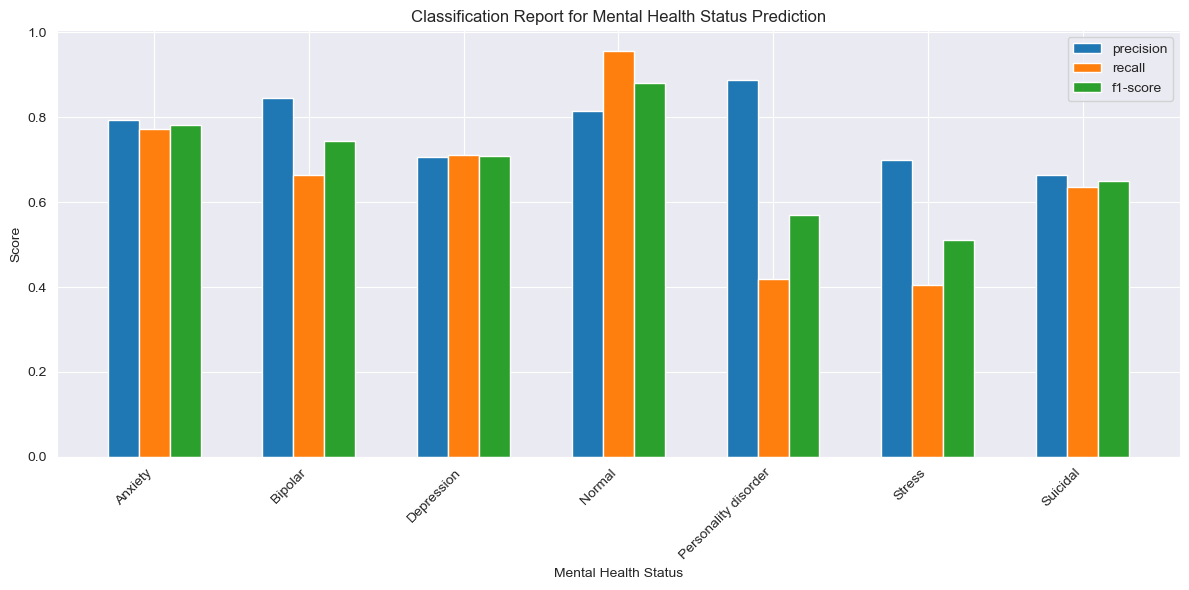

In [122]:
report = classification_report(y_test, y_pred_LR, target_names=label_encoder.classes_, output_dict=True)

categories = list(report.keys())[:-3]
metrics = ['precision', 'recall', 'f1-score']
data = np.array([[report[category][metric] for metric in metrics] for category in categories])

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
x_pos = np.arange(len(categories))

for i, metric in enumerate(metrics):
    ax.bar(x_pos + i * bar_width, data[:, i], bar_width, label=metric)

ax.set_xlabel('Mental Health Status')
ax.set_ylabel('Score')
ax.set_title('Classification Report for Mental Health Status Prediction')
ax.set_xticks(x_pos + bar_width)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

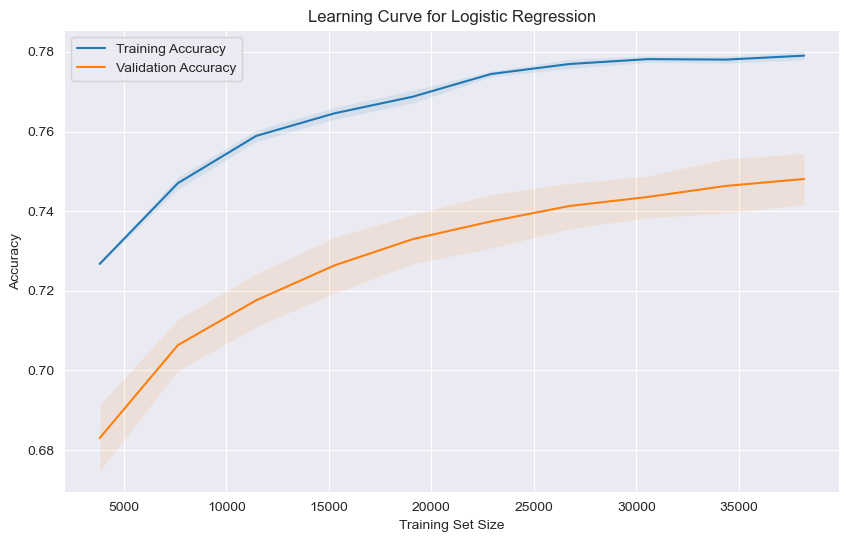

In [123]:
train_sizes, train_scores, test_scores = learning_curve(
    best_LR, X_train, y_train, cv=kf, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

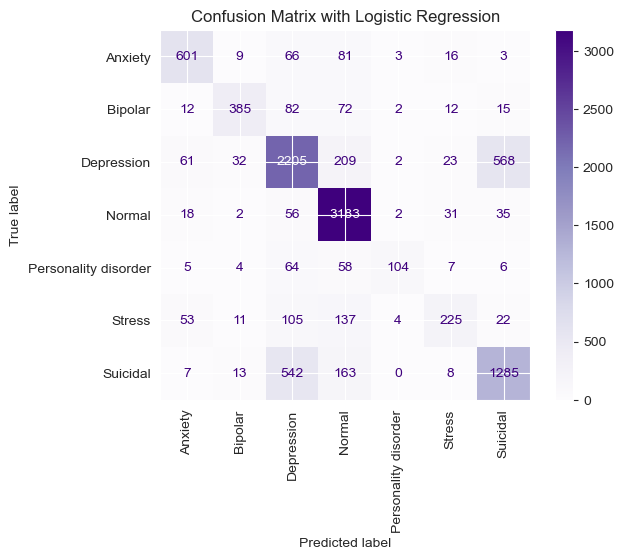

In [124]:
# Generate confusion matrix
cm_LR = confusion_matrix(y_test, y_pred_LR)

# Display the confusion matrix with a new color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LR, display_labels=label_encoder.classes_)
disp.plot(cmap='Purples', xticks_rotation='vertical')

# Adjust font size and layout if necessary
plt.title("Confusion Matrix with Logistic Regression")
plt.show()


## Conclusion
In this project, we aimed to classify text into different mental health statuses using a large dataset. Initially, we experimented with several models, including Logistic Regression, Random Forest, and HistGradientBoostingClassifier. While Logistic Regression performed reasonably well, achieving an overall accuracy of 75%, Random Forest performed poorly with an accuracy of 68%, leading us to exclude it from further analysis. The HistGradientBoostingClassifier, though promising, proved to be computationally expensive, taking over an hour to run on a powerful desktop. Due to these heavy computational requirements, the rest of the team could not run it on their machines, which prompted us to discard it as well.

Ultimately, we decided to proceed with Logistic Regression due to its consistent performance across categories, achieving a good balance between computational efficiency and predictive accuracy. The model produced the highest F1 score of 0.88 in the "Normal" category, followed by "Anxiety" and "Bipolar" with F1 scores of 0.78 and 0.74, respectively. However, categories like "Personality Disorder" and "Stress" were more challenging, with lower F1 scores, indicating their complexity and overlap in features. The confusion matrix showed fewer misclassifications compared to previous iterations, thanks to effective data preprocessing and TF-IDF feature extraction.


## Distribution of Work:
* Haoran Chen: Contributed to training and hyperparameter tuning for the Logistic Regression model in the final project. He also contributed to the midterm report and edited its IEEE Conference version. Additionally, he was responsible for both the content and layout of our project poster.

* Fort Hunter: Focused on data processing and exploratory data analysis (EDA). He contributed significantly to visualizing the data, adding 90% of the graphs in the final project. Fort also contributed to the creation of the poster's content and the midterm report.

* Ngan Huynh: Contributed significantly to the coding aspects of the project. She worked closely with the team to review and compare results, seeking improvements when necessary. Ngan applied a variety of text-preprocessing techniques to retain the most relevant information for training. She explored different methods at each stage of the project, including researching and utilizing efficient tools, identifying patterns in the dataset, and reducing outliers while preserving important terms. Ngan also helped in training and hyperparameter tuning the Logistic Regression model, working with other models, and selecting the best-performing model for the final project. Additionally, she contributed to visualizing the results. She documented her understanding and experiences with the tools used in both the midterm report and this final notebook, and she also added comments throughout the notebook to clarify the steps and processes. 